## Mathematical Foundations of Computer Graphics and Vision 2023
## Exercise 2 - Global Optimization

In this exercise you will apply what you learned about global optimization, especially branch and bound (B&B), concave and convex envelopes, and reformulation. You will implement branch and bound for consensus set maximization.

<b style="color:red"> TODO A: </b>:  Derivation of the problem formulation in the canonical form of Linear Programming. Please explain all your steps clearly. You may use the hints and notation from section 2 of the excercise sheet.

Your answer here (Type *Markdown* and LaTeX: $\alpha^2$)

#### Branch and Bound Implementation for the Consensus Set Maximization Problem

<b style="color:red"> TODO B: </b>In the following code you are supposed to implement consensus set maximization by branch and bound in the context of stereo matching where the model is a 2D translation between two input images. Please use the imports listed in the cell down. You may also add more imports for example for visualization purposes if you find them useful.


In [1]:
%matplotlib inline
import math
import heapq
from typing import Tuple, List, Optional
from collections import namedtuple
import os

import numpy as np
from scipy.io import loadmat
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


# Translation Theta
T = namedtuple("T", ["x", "y"])

# Load input points, input image and fix delta parameter
corr = loadmat('data/ListInputPoints')['ListInputPoints'] # correspondences (nx4 array) [x_i,y_i,x_i',y_i']
N = corr.shape[0]  # number of total points

left_image = plt.imread('data/InputLeftImage.png')
right_image = plt.imread('data/InputRightImage.png')
image_size = left_image.shape

h,w,_=image_size
theta_lower= T(x=-w, y=-h)
theta_upper=T(x=w, y=h)
objlower =T(x=0, y=0)
objupper=T(x=55, y=55)
delta = 3  # inlier threshold [pixels]

We provide you some skeleton code that you are free to use as it is or where you can also add/ delete parameters.
You may also write auxiliary functions if you feel the need to do so.

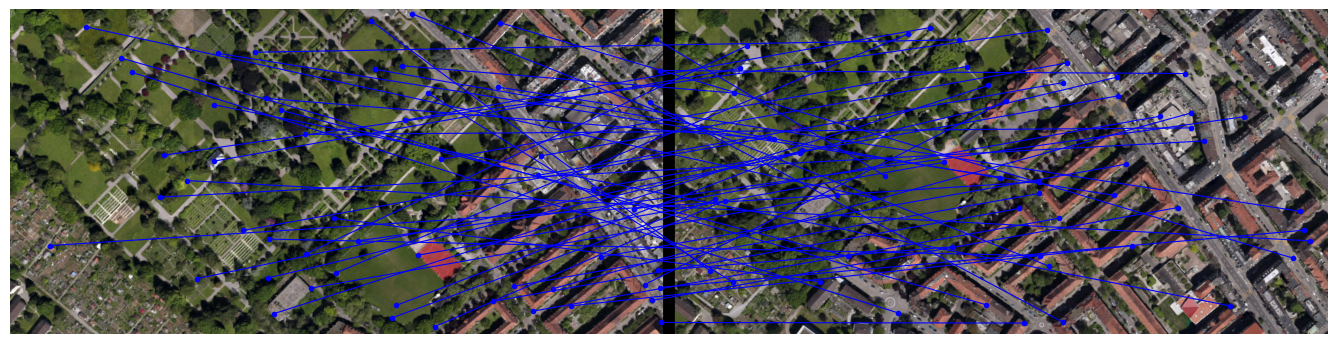

In [2]:
def plot_matches(inliers: List, outliers: List):
    fig, ax = plt.subplots(1, figsize=(17, 7))
    
    gap = np.zeros_like(left_image[:, :20])
    stitched = np.concatenate((left_image, gap, right_image), 1)
    ax.imshow(stitched)
    
    offset = left_image.shape[1] + gap.shape[1]

    for idx, line in enumerate(corr):
        x1, y1, x2, y2 = line
        if idx in inliers:
            color = "lime"
        elif idx in outliers:
            color = "crimson"
        else:
            color = "blue"
        
        ax.plot([x1, offset + x2], [y1, y2], ".-", color=color, linewidth=0.8)

    ax.axis('off')
    plt.show(fig)
    plt.close(fig)


plot_matches(inliers=[], outliers=[])

To help with implementing and debugging BnB, we provide a naive estimation of the inlier upper bound within box constraints of $[\underline{T_x}, \overline{T_x}]\times[\underline{T_y}, \overline{T_y}]$.

In [3]:
def naive_upper_bound(theta_lower: T, theta_upper: T) -> Tuple[T, int]:
    """
    Naive estimation of the upper bound on objective
    Calculates number of inliers in region [Tx_lb, Tx_ub]x[Ty_lb, Ty_ub]

    Parameters:
    - theta_lower, theta_upper: Lower and upper bounds for T

    Returns:
    - Tuple (translation, objcost) representing the estimated upper bound on the model and the objective
    """

    x1, y1, x2, y2 = corr.T
    
    T_x = x2 - x1
    T_y = y2 - y1
    
    inliers = (((T_x + delta) >= theta_lower.x) *
               ((T_y + delta) >= theta_lower.y) *
               ((T_x - delta) <= theta_upper.x) *
               ((T_y - delta) <= theta_upper.y))
    
    #Set center of region as new model
    theta = T(0.5 * (theta_lower.x + theta_upper.x), 0.5 * (theta_lower.y + theta_upper.y))

    return theta, np.sum(inliers)


In [24]:
def solve_relaxed_LP(theta_lower: T, theta_upper: T) -> Tuple[T, int]:
    # Decision variables: [T_x, T_y, z_1, ..., z_N, w_1x, ..., w_Nx, w_1y, ..., w_Ny]
#N=55 shape of x=3N+2=167
    c = np.concatenate(([0, 0], -np.ones(N), np.zeros(2 * N)))  # Coefficients for the objective function
    # # Bounds for each variable
    bounds = [(theta_lower.x, theta_upper.x), (theta_lower.y, theta_upper.y)] + \
                [(0, 1)] * N + [(None, None)] * (2 * N)  # Bounds for T_x, T_y, z_i's, w_ix's, and w_iy's

    # # Constructing the inequality constraints A_ub * x <= b_ub
    A_ub = []
    b_ub = []

    for i in range(N):
        x_i, y_i, x_i_prime, y_i_prime = corr[i]
        # print(x_i, y_i, x_i_prime, y_i_prime)
        # Constraints for x-coordinate #TxTy,z,wx,wy
        A_ub.append([0, 0] + [x_i - x_i_prime - delta if j == i else 0 for j in range(N)] + [1 if j == i else 0 for j in range(N)] + [0] * N)
        b_ub.append(0)
        
        A_ub.append([0, 0] + [-x_i + x_i_prime - delta if j == i else 0 for j in range(N)] + [-1 if j == i else 0 for j in range(N)] + [0] * N)
        b_ub.append(0)
        
        # Constraints for y-coordinate
        A_ub.append([0, 0] + [y_i - y_i_prime - delta if j == i else 0 for j in range(N)] + [0] * N + [1 if j == i else 0 for j in range(N)])
        b_ub.append(0)
        
        A_ub.append([0, 0] + [-y_i + y_i_prime - delta if j == i else 0 for j in range(N)] + [0] * N + [-1 if j == i else 0 for j in range(N)])
        b_ub.append(0)
        
        # wix
        
        A_ub.append([0, 0] + [theta_lower.x if j == i else 0 for j in range(N)] + [-1 if j == i else 0 for j in range(N)] + [0] * N)
        b_ub.append(0)
        
        A_ub.append([1, 0] + [theta_upper.x if j == i else 0 for j in range(N)] + [-1 if j == i else 0 for j in range(N)] + [0] * N)
        b_ub.append(theta_upper.x)
        
        A_ub.append([-1, 0] + [-theta_lower.x if j == i else 0 for j in range(N)] + [1 if j == i else 0 for j in range(N)] + [0] * N)
        b_ub.append(theta_lower.x)
        
        A_ub.append([0, 0] + [theta_upper.x if j == i else 0 for j in range(N)] + [1 if j == i else 0 for j in range(N)] + [0] * N)
        b_ub.append(0)

        # #wiy
        A_ub.append([0, 0] + [theta_lower.y if j == i else 0 for j in range(N)] + [0] * N + [-1 if j == i else 0 for j in range(N)])
        b_ub.append(0)
        
        A_ub.append([0, 1] + [theta_upper.y if j == i else 0 for j in range(N)] + [0] * N + [-1 if j == i else 0 for j in range(N)])
        b_ub.append(theta_upper.y)        

        
        A_ub.append([0, -1] + [-theta_lower.y if j == i else 0 for j in range(N)] + [0] * N + [1 if j == i else 0 for j in range(N)])
        b_ub.append(theta_lower.y)
        
        A_ub.append([0, 0] + [theta_upper.y  if j == i else 0 for j in range(N)] + [0] * N + [1 if j == i else 0 for j in range(N)])
        b_ub.append(0)    
        
    A_ub = np.array(A_ub)
    b_ub = np.array(b_ub)

    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    if result.success:
        T_x, T_y = result.x[:2]
        num_inliers = -np.sum(result.x[2:2 + N])  # Negative because we minimized the negative sum of z_i's
        theta = T(T_x, T_y)
        print("nice")
    else:
        theta = T(0, 0)  # Default to (0, 0) if LP fails
        num_inliers = 0
        print("not nice")

    return theta, num_inliers

In [5]:
def is_inlier(theta: T) -> np.ndarray:
    """
    Parameters:
    - theta - model that's being tested
    
    Returns:
    - bool vector f size N, where i-th element indicates if i-th point of `corr` is an inlier
    """

    #TODO: Compute if i-th element is an inliers
    # inliers = ...
    x, y, xprime, yprime = corr.T  # Unpack the correspondence columns into x and y coordinates
    
    # Apply the model (translation) to the first set of points
    x_translated = x + theta.x
    y_translated = y + theta.y
    
    # Compute the distances between translated points and their correspondences in the second image
    distancesx = np.sqrt(( x_translated-xprime) ** 2 )
    distancesy= np.sqrt(( y_translated-yprime) ** 2)    
    # Determine inliers: points for which the distance is less than or equal to delta
    inliers = np.logical_and(distancesx <= delta ,distancesy<=delta)
    
    return inliers

In [13]:
def consensus_set_maximization_by_bnb(image_size: Tuple[int, int], upper_bound_fn) -> Tuple[T, List[int], List[int]]:
    """
    Parameters:
    - image_size - tuple of image size (H, W)

    Returns a tuple of
    - Best model according to the BnB algorithm
    - list of upper bounds for each iteration
    - list of lower bounds for each iteration
    """
    
    h, w, _ = image_size

    best_model = T(0, 0)
    upper_bounds = []
    lower_bounds = []

    #TODO: Implement BnB

    return best_model, lower_bounds, upper_bounds


In [87]:
def consensus_set_maximization_by_bnb(image_size: Tuple[int, int], upper_bound_fn) -> Tuple[T, List[int], List[int]]:
    """
    Parameters:
    - image_size - tuple of image size (H, W)

    Returns a tuple of
    - Best model according to the BnB algorithm
    - list of upper bounds for each iteration
    - list of lower bounds for each iteration
    """
    
    h, w, _ = image_size

    best_model = T(0, 0)
    upper_bounds = []
    lower_bounds = []
    #TODO: Implement BnB
    theta_lower_initial=T(-w, -h)
    theta_upper_initial=T(w, h)
    
    priority_queue = [(theta_lower_initial, T(w, h))]  # Start with bounds covering the whole image
    priority_queue = [(-float('inf'), (theta_lower_initial, theta_upper_initial))]

    best_num_inliers = -2

    while priority_queue:
        # Get the search space with the highest upper bound
        _, (theta_lower, theta_upper) = heapq.heappop(priority_queue)
        print("lower",theta_lower,theta_upper)
        # Compute the upper bound for this search space by solving the LP
        _, num_inliers_upper = solve_relaxed_LP(theta_lower, theta_upper)
        upper_bounds.append(num_inliers_upper)
        print("upper bounds",upper_bounds)
        if num_inliers_upper <= best_num_inliers:
            print("continuing",num_inliers_upper,best_num_inliers)
            continue  # Prune this search space

        # Compute the lower bound for this search space
        mid_point = T((theta_lower.x + theta_upper.x) / 2, (theta_lower.y + theta_upper.y) / 2)
        model, num_inliers_lower = some_lower_bound_function(mid_point)
        lower_bounds.append(num_inliers_lower)
        print("mid",mid_point)
        if num_inliers_lower > best_num_inliers:
            best_num_inliers = num_inliers_lower
            best_model = model

        # Branch: Split the current space along the longest dimension
        if (theta_upper.x - theta_lower.x) > (theta_upper.y - theta_lower.y):
            mid_x = (theta_lower.x + theta_upper.x) / 2
            subspaces = [
                (T(theta_lower.x, theta_lower.y), T(mid_x, theta_upper.y)),
                (T(mid_x, theta_lower.y), T(theta_upper.x, theta_upper.y))
            ]
        else:
            mid_y = (theta_lower.y + theta_upper.y) / 2
            subspaces = [
                (T(theta_lower.x, theta_lower.y), T(theta_upper.x, mid_y)),
                (T(theta_lower.x, mid_y), T(theta_upper.x, theta_upper.y))
            ]

        for subspace in subspaces:
            # Compute the upper bound for the new subspace
            _, subspace_num_inliers_upper = solve_relaxed_LP(subspace[0], subspace[1])
            
            # Add the new subspace to the priority queue if its upper bound is promising
            if subspace_num_inliers_upper > best_num_inliers:
                heapq.heappush(priority_queue, (-subspace_num_inliers_upper, subspace))

        # Stopping condition: The difference between the best lower and upper bounds is less than 1
        if not priority_queue or (max(upper_bounds) - best_num_inliers) < 1:
            break

    return best_model, lower_bounds, upper_bounds


In [139]:
def consensus_set_maximization_by_bnb(image_size: Tuple[int, int], upper_bound_fn) -> Tuple[T, List[int], List[int]]:
    """
    Parameters:
    - image_size - tuple of image size (H, W)

    Returns a tuple of
    - Best model according to the BnB algorithm
    - list of upper bounds for each iteration
    - list of lower bounds for each iteration
    """
    
    h, w, _ = image_size

    best_model = T(0, 0)
    upper_bounds = []
    lower_bounds = []
    #TODO: Implement BnB
    theta_lower_initial=T(-w+4, -h+6)
    theta_upper_initial=T(w, h)
    
    priority_queue = [(theta_lower_initial, theta_upper_initial)]  # Start with bounds covering the whole image
    # priority_queue = [(-float('inf'), (theta_lower_initial, theta_upper_initial))]

    best_num_inliers = -2
    while priority_queue:

        # while search_space:
            # Get the search space with the highest upper bound
            
        theta_lower, theta_upper = priority_queue.pop()
        
        print(theta_lower)
        
        # Calculate the relaxed LP for the current bounds to get a lower bound on the number of inliers
        theta, num_inliers = solve_relaxed_LP(theta_lower, theta_upper)
        lower_bounds.append(num_inliers)
        # print("low",theta_lower.x,theta_upper.x)
        mid_point = T((theta_lower.x + theta_upper.x) / 2, (theta_lower.y + theta_upper.y) / 2)
        print(mid_point,"mid")
        model, num_inliers_lower = some_lower_bound_function(mid_point,corr,delta)
        lower_bounds.append(num_inliers_lower)
        
        print(num_inliers_lower,"lower")
        
        if (theta_upper.x - theta_lower.x) > (theta_upper.y - theta_lower.y):
            mid_x = (theta_lower.x + theta_upper.x) / 2
            subspaces = [
                (T(theta_lower.x, theta_lower.y), T(mid_x, theta_upper.y)),
                (T(mid_x, theta_lower.y), T(theta_upper.x, theta_upper.y))
            ]
        else:
            mid_y = (theta_lower.y + theta_upper.y) / 2
            subspaces = [
                (T(theta_lower.x, theta_lower.y), T(theta_upper.x, mid_y)),
                (T(theta_lower.x, mid_y), T(theta_upper.x, theta_upper.y))
            ]
        for subspace in subspaces:
            # Compute the upper bound for the new subspace
            _, subspace_num_inliers_upper = solve_relaxed_LP(subspace[0], subspace[1])
            
            # Add the new subspace to the priority queue if its upper bound is promising
            if subspace_num_inliers_upper > best_num_inliers:
                heapq.heappush(priority_queue, (-subspace_num_inliers_upper, subspace))

        # Stopping condition: The difference between the best lower and upper bounds is less than 1
        if not priority_queue or (max(upper_bounds) - best_num_inliers) < 1:
            break
    # print("thefsdafsdaa",theta,num_inliers)
    # print("mid_point",mid_point,num_inliers,model,num_inliers_lower)

        # _, (theta_lower, theta_upper) = heapq.heappop(search_space)
        # print("lower",theta_lower,theta_upper)
        # # Compute the upper bound for this search space by solving the LP
        # _, num_inliers_upper = solve_relaxed_LP(theta_lower, theta_upper)
        # upper_bounds.append(num_inliers_upper)
        # print("upper bounds",upper_bounds)
        # if num_inliers_upper <= best_num_inliers:
        #     print("continuing",num_inliers_upper,best_num_inliers)
        #     continue  # Prune this search space

        # # Compute the lower bound for this search space
        # mid_point = T((theta_lower.x + theta_upper.x) / 2, (theta_lower.y + theta_upper.y) / 2)
        # model, num_inliers_lower = some_lower_bound_function(mid_point)
        # lower_bounds.append(num_inliers_lower)
        # print("mid",mid_point)
        # if num_inliers_lower > best_num_inliers:
        #     best_num_inliers = num_inliers_lower
        #     best_model = model

        # # Branch: Split the current space along the longest dimension
        # if (theta_upper.x - theta_lower.x) > (theta_upper.y - theta_lower.y):
        #     mid_x = (theta_lower.x + theta_upper.x) / 2
        #     subspaces = [
        #         (T(theta_lower.x, theta_lower.y), T(mid_x, theta_upper.y)),
        #         (T(mid_x, theta_lower.y), T(theta_upper.x, theta_upper.y))
        #     ]
        # else:
        #     mid_y = (theta_lower.y + theta_upper.y) / 2
        #     subspaces = [
        #         (T(theta_lower.x, theta_lower.y), T(theta_upper.x, mid_y)),
        #         (T(theta_lower.x, mid_y), T(theta_upper.x, theta_upper.y))
        #     ]

        # for subspace in subspaces:
        #     # Compute the upper bound for the new subspace
        #     _, subspace_num_inliers_upper = solve_relaxed_LP(subspace[0], subspace[1])
            
        #     # Add the new subspace to the priority queue if its upper bound is promising
        #     if subspace_num_inliers_upper > best_num_inliers:
        #         heapq.heappush(search_space, (-subspace_num_inliers_upper, subspace))

        # # Stopping condition: The difference between the best lower and upper bounds is less than 1
        # if not search_space or (max(upper_bounds) - best_num_inliers) < 1:
        #     break

    return best_model, lower_bounds, upper_bounds


In [110]:
def some_lower_bound_function(model: T, correspondences: List[Tuple[float, float, float, float]], delta: float) -> Tuple[T, int]:
    """
    Compute the lower bound of the number of inliers for a given model.
    
    Parameters:
    - model: A named tuple T(x, y) representing the translation model (T_x, T_y).
    - correspondences: A list of tuples, each representing a correspondence (x_i, y_i, x'_i, y'_i).
    - delta: The inlier threshold.
    
    Returns:
    - The model (unchanged in this function).
    - The number of inliers as the lower bound.
    """
    num_inliers = 0
    
    # Iterate through each correspondence and apply the model
    for (x_i, y_i, x_i_prime, y_i_prime) in correspondences:
        # Apply the translation model to the points in the first image
        transformed_x = x_i + model.x
        transformed_y = y_i + model.y
        
        # Check if the transformed point is within delta of the point in the second image
        if abs(transformed_x - x_i_prime) <= delta and abs(transformed_y - y_i_prime) <= delta:
            # The correspondence is an inlier
            num_inliers += 1
            
    return model, num_inliers

In [82]:
def plot_bound_convergence(lower_bounds: List[int], upper_bounds: List[int]):
    fig, ax = plt.subplots(1, figsize=(17, 7))
    
    iterations = np.arange(len(lower_bounds)) + 1
    
    # Draw lines
    ax.plot(iterations, lower_bounds, marker="o", color="r")
    ax.plot(iterations, upper_bounds, marker="o", color="b")
    
    # Write titles
    ax.set_title("Convergence of Bounds")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Upper and Lower Bounds")
    ax.legend(["Lower Bound", "Upper Bound"], loc="upper right")
    ax.xaxis.set_major_locator(MultipleLocator(1 if len(lower_bounds) < 20 else 5))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.grid(True)

    plt.show(fig)
    plt.close(fig)


In [140]:
def perform_bnb(upper_bound_fn):
    
    #perform consensus set maximization
    best_model, lower_bounds, upper_bounds = consensus_set_maximization_by_bnb(image_size, upper_bound_fn)
    print("dsf",best_model)
    inliers = is_inlier(best_model)
    inliers_indices = np.where(inliers)[0]
    outliers_indices = np.where(~inliers)[0]
    
    print(f"Global optimal translational model (Tx, Ty) = {best_model}")
    print(f"Inlier set S_I: {inliers_indices} ({len(inliers_indices)} points)")
    print(f"Outlier indices S_O = S\S_I: {outliers_indices}")
    
    plot_matches(inliers_indices, outliers_indices)
    
    # plot_bound_convergence(lower_bounds, upper_bounds)


#### Results

<b style="color:red"> TODO C-E: </b> Present and discuss your results. Also plot the figures described in the deliverables D and E.

In [141]:
# Display results with the naive upper bound
perform_bnb(naive_upper_bound)


NameError: name 'search_space' is not defined

T(x=-1104, y=-549)
nice
thefsdafsdaa T(x=1104.0, y=549.0) -0.0
dsf T(x=0, y=0)
Global optimal translational model (Tx, Ty) = T(x=0, y=0)
Inlier set S_I: [] (0 points)
Outlier indices S_O = S\S_I: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]


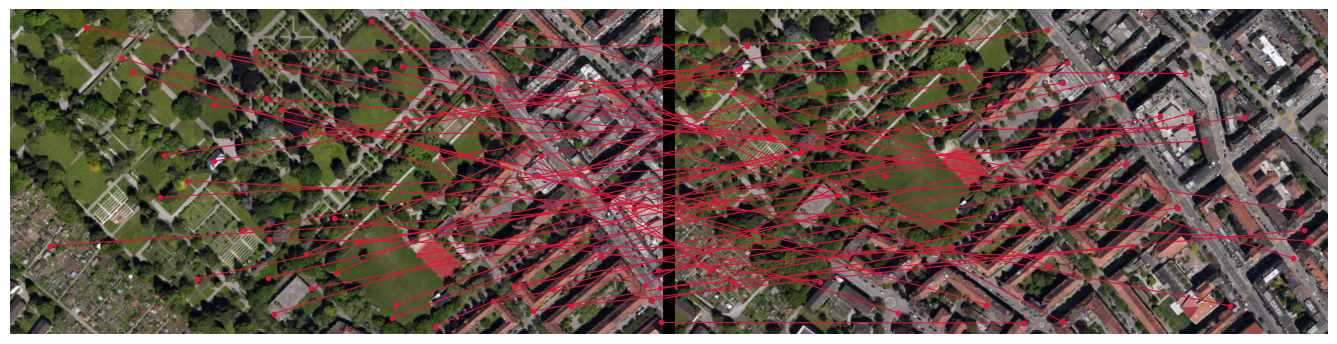

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

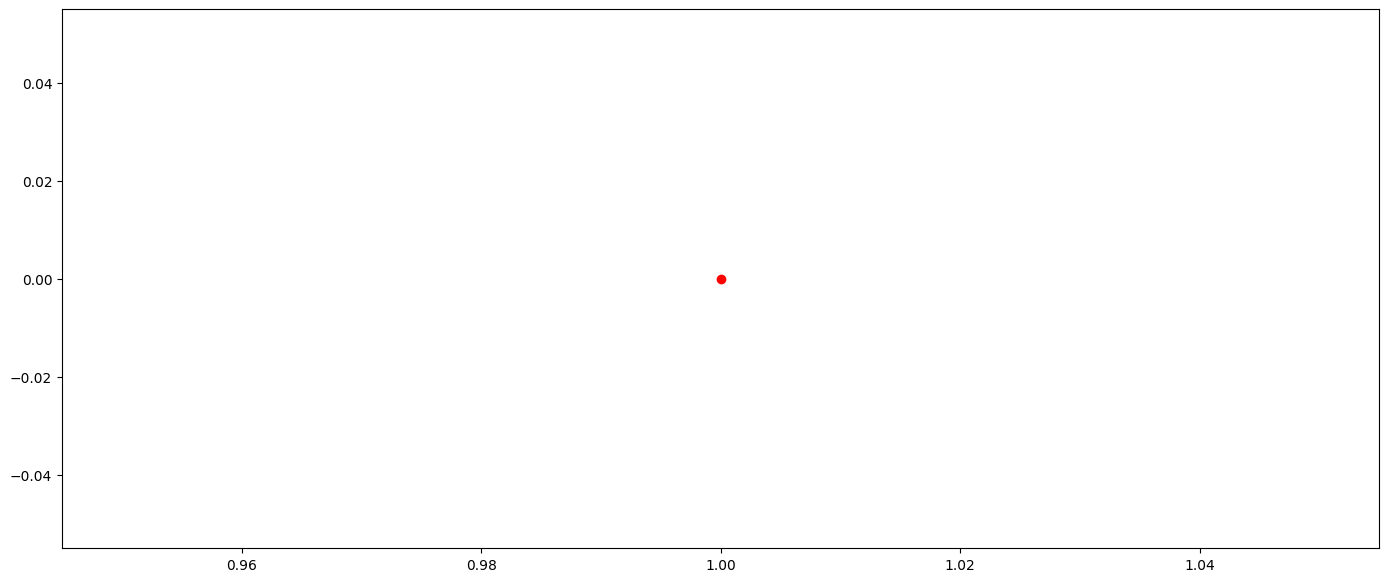

In [102]:
# Display results with the LP upper bound
perform_bnb(solve_relaxed_LP)

<b style="color:red"> Discussion (not graded): </b> In the previous exercise, you implemented RANSAC to fit polynomials. Now, can you use RANSAC to solve the consensus set maximization problem for stereo matching? If so, please briefly describe the main steps you would take to implement RANSAC for this task, and compare it with the BnB approach. Additionally, can you identify scenarios where one approach may be more effective than the other? If not, explain why it is not feasible to adapt RANSAC for this application. Can you also combine RANSAC and BnB in one pipeline?

_TODO_: Your answer here